In [1]:
import sys; sys.path.append(".")

%reload_ext autoreload
%autoreload 2

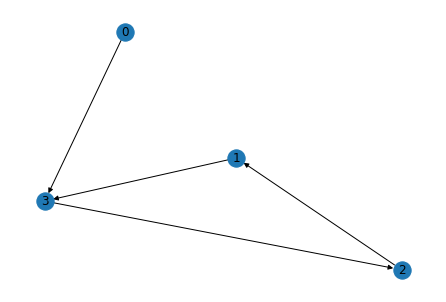

In [2]:
import networkx as nx

in_degrees = [0, 1, 1, 2]
out_degrees = [1, 1, 1, 1]
nkk = {1: {1: 2, 2: 2}}
G = nx.directed_joint_degree_graph(in_degrees, out_degrees, nkk)
nx.draw(G, with_labels=True)

In [3]:
import networkx as nx

def twitter():
    G = nx.DiGraph()
    with open("twitter.txt", "r") as lines:
        for line in lines:
            a, b = line.split()
            G.add_edge(int(a), int(b))
    return G

def enron():
    G = nx.DiGraph()
    with open("enron.txt", "r") as lines:
        for line in lines:
            if (line.startswith('#')):
                continue
            a, b = line.split()
            G.add_edge(int(a), int(b))
    return G



twitter_G = twitter()

In [4]:
from random import choice, random
from tabulate import tabulate

def cascade(G, retweet_prob = 0.07, candidates = [], table = True):
    start = choice(list(G.nodes()))

    retweet_prob = 0.04

    S = list()
    S.append(start)
    visited = set()

    while S:
        curr = S.pop()

        if curr in visited or curr in candidates:
            continue

        visited.add(curr)
        neighbors = list(G.predecessors(curr))
        for neighbor in neighbors:
            if random() < retweet_prob:
                S.append(neighbor)

    N = G.number_of_nodes()
    V = len(visited)
    if table:
        print(
            tabulate(
                [
                    ["RETWEET PROBABILITY", retweet_prob],
                    ["N", N],
                    ["V", V],
                    ["CASCADE SIZE (V / N)", round(V / N, 2)],
                ],
                tablefmt="fancy_grid",
                numalign="left",
            )
        )
    else:
        return str(round(V / N, 2))

cascade(twitter_G, table=False)

'0.0'

In [6]:
def joint_degree_distribution_directed(G):
    outer_dict = dict()
    for edge in G.edges:
        out_deg = G.out_degree(edge[0])
        in_deg = G.in_degree(edge[1])
        if (out_deg in outer_dict):
            if (in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] += 1
            else:
                outer_dict[out_deg][in_deg] = 1
        else:
            outer_dict[out_deg] = dict()
            outer_dict[out_deg][in_deg] = 1
    return outer_dict
    
def joint_degree_distribution_undirected(G):
    outer_dict = dict()
    for edge in G.edges:
        out_deg = G.degree(edge[0])
        in_deg = G.degree(edge[1])
        if (out_deg in outer_dict):
            if (in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] += 1
            else:
                outer_dict[out_deg][in_deg] = 1
        else:
            outer_dict[out_deg] = dict()
            outer_dict[out_deg][in_deg] = 1
    return outer_dict

twitter_jdd = joint_degree_distribution_directed(twitter_G)


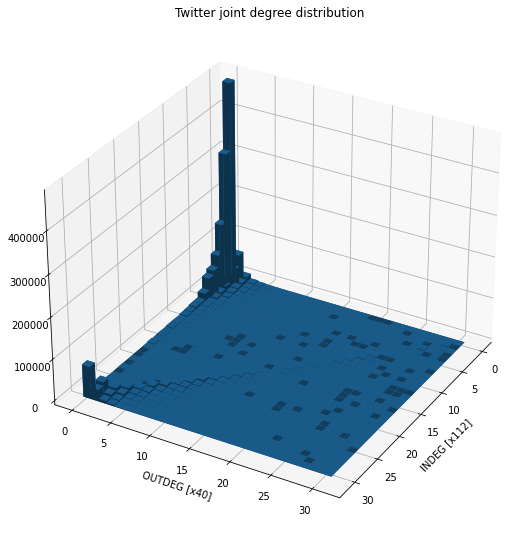

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_jdd(G, jdd, name):
    max_in = max(list(map(lambda x: x[1], G.in_degree(G.nodes))))
    max_out = max(list(map(lambda x: x[1], G.out_degree(G.nodes))))
    max_in, max_out

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(121, projection="3d")

    size = 30
    x_step = max_in // size
    y_step = max_out // size
    _x = np.arange(size + 1)
    _y = np.arange(size + 1)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    ax.set_xlabel(f"INDEG [x{x_step}]")
    ax.set_ylabel(f"OUTDEG [x{y_step}]")

    z = np.zeros_like(x)
    for i in jdd.keys():
        t = jdd[i]
        for key, val in jdd[i].items():
            a = i // y_step
            b = key // x_step
            z[a + b * size] += val

    bottom = np.zeros_like(z)
    width = depth = 1

    ax.bar3d(x, y, bottom, width, depth, z, shade=True)
    ax.set_title(name + " joint degree distribution")
    ax.azim = 30

    plt.show()

plot_jdd(twitter_G, twitter_jdd, 'Twitter')

In [13]:
candidates = []
for node in list(twitter_G.nodes()):
    indeg = twitter_G.in_degree(node)
    outdeg = twitter_G.out_degree(node)
    
    _x = indeg // x_step
    _y = outdeg // y_step

    if abs(_x + _y - size) < 10:
        candidates.append(node)

34428380 2462 51
40981798 3216 119
22462180 2471 64
43003845 2735 105
7861312 2074 224
7860742 1098 513
18581803 529 930
5442012 894 1069
22679419 852 705
115485051 3383 1
17093617 1186 687
17092592 697 631
18776017 1022 719
15846407 743 724
208132323 479 713


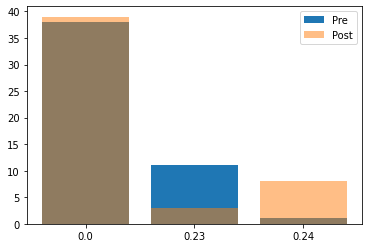

In [43]:
from collections import defaultdict

N = 500
retweet_prob = 0.07
hist_pre = defaultdict(int)
hist_post = defaultdict(int)

for i in range(N):
    hist_pre[cascade(twitter_G, retweet_prob, [], False)] += 1

for i in range(N):
    hist_post[cascade(twitter_G, retweet_prob, candidates, False)] += 1

plt.bar(range(len(hist_pre)), list(hist_pre.values()), align="center", label="Pre")
plt.xticks(range(len(hist_pre)), list(hist_pre.keys()))

plt.bar(range(len(hist_post)), list(hist_post.values()), align="center", alpha=0.5, label="Post")
plt.xticks(range(len(hist_post)), list(hist_post.keys()))
plt.legend()

Od tu naprej irrelevant

In [61]:
x = [] 
y = []
z = []

for out_key, out_value in jdd.items():
    for in_key, in_value in jdd[out_key].items():
        x.append(out_value)
        y.append(in_value)
        z.append(jdd[out_key][in_key])

print(x)
print(y)
print(z)

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def inter_hist(ivls, n_bins = 10):
    imin, imax = ivls.min(), ivls.max()
    values = np.arange(imin,imax+1)
    counts = np.zeros(values.shape)
    for i,j in (ivls-imin): 
        counts[i:j+1] += 1
 
    bins = np.arange(imin, imax+1, ((imax-imin)/n_bins))
    plt.hist(values, bins, weights=counts)

intervals = np.array([x,y,z])
inter_hist(intervals)

ValueError: too many values to unpack (expected 2)

In [ ]:
x = [] 
y = []
z = []

for i in range(len(jdd)):
    if (i in jdd):
        x.append()

TypeError: float() argument must be a string or a number, not 'dict'

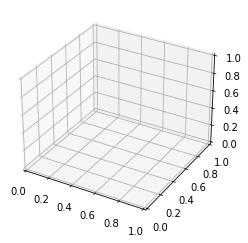

In [56]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='y', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

ValueError: cannot reshape array of size 154911 into shape (3383,1205)

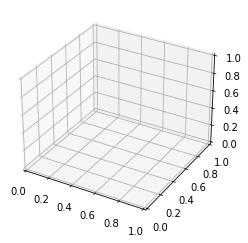

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# setup the figure and axes
#fig = plt.figure(figsize=(8, 3))
#ax1 = fig.add_subplot(121, projection='3d')
#ax2 = fig.add_subplot(122, projection='3d')

# fake data
'''
_x = np.arange(3383)
_y = np.arange(1205)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.reshape(x, (3383, 1205))
y = np.reshape(y, (3383, 1205))
z = np.reshape(z, (3383, 1205))

ax.plot_surface(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()